In [1]:
%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd

from oanda_api import download_all_history
from pyoanda import Client, PRACTICE

In [2]:
data = download_all_history(
    pair="SPX500_USD",
    granularity="M", # Monthly
    num_bars=10000, # Lots
    fname="spx.csv",
)



fetching data, data so far: 0


In [22]:
data['date'] = pd.to_datetime(data.index)
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month

In [23]:
data['close'] = (data['SPX500USD_closeAsk'].values +  data['SPX500USD_closeBid'].values) / 2.0

data['returns'] = 0
data.iloc[1:, list(data.columns).index('returns')] = (data.close.values[1:] - data.close.values[:-1]) / data.close.values[:-1]

long = 6
data['returns_long'] = np.nan
data.iloc[long:, list(data.columns).index('returns_long')] = (data.close.values[long:] - data.close.values[:-long]) / data.close.values[:-long]

signal = np.sign(data.returns_long.values)
signal[signal != 1] = 0

data['signal'] = 0
data.iloc[1:, list(data.columns).index('signal')] = signal[:-1]

data['trade_returns'] = data.returns.values * data.signal.values

data['leveraged_trade_returns'] = data.trade_returns.values * np.std(data.returns.values) / np.std(data.trade_returns.values)

,SPX500USD_closeAsk,SPX500USD_closeBid,SPX500USD_complete,SPX500USD_highAsk,SPX500USD_highBid,SPX500USD_lowAsk,SPX500USD_lowBid,SPX500USD_openAsk,SPX500USD_openBid,SPX500USD_volume,date,close,returns,returns_long,signal,trade_returns,leveraged_trade_returns,year,month
time,,,,,,,,,,,,,,,,,,,
2013-01-31T22:00:00.000000Z,1511.0,1509.5,True,1531.9,1531.4,1483.9,1482.4,1499.8,1498.3,134630,2013-01-31 22:00:00,1510.25,0.007673,0.073116,1.0,0.007673,0.011617,2013,1


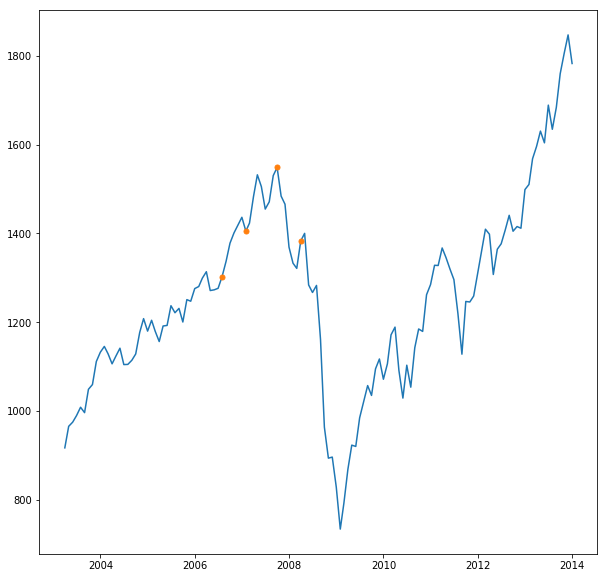

In [37]:
sub = data[data.date < '2014-01-01']

target = sub[
    ((sub.year == 2006) & (sub.month == 7))
    | ((sub.year == 2007) & (sub.month == 1))
    
    | ((sub.year == 2007) & (sub.month == 9))
    | ((sub.year == 2008) & (sub.month == 3))
]

figure(figsize=(10, 10))

plot(sub.date, sub.close)
plot(target.date, target.close, '.', markersize=10)

savefig('example.svg')

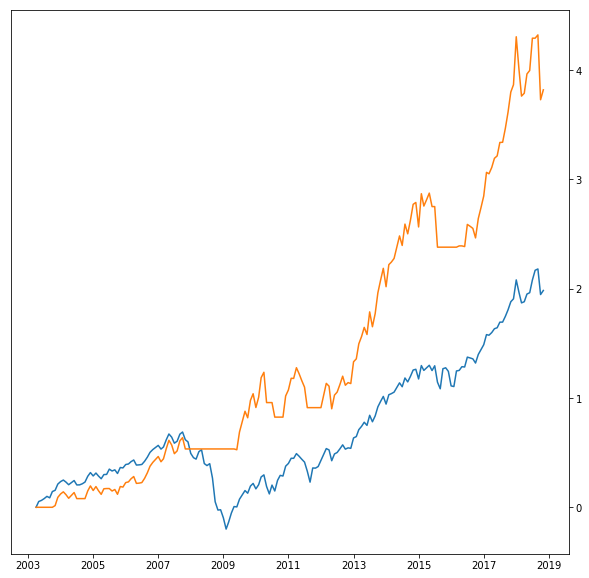

In [38]:
tr = np.cumprod(1 + data.leveraged_trade_returns.values) - 1
r = np.cumprod(1 + data.returns.values) - 1

figure(figsize=(10, 10))

plot(data.date, r)
plot(data.date, tr)

ax = gca()

ax.yaxis.tick_right()

savefig('results.svg')